# RCC Predictions with PLS and RF Feature Selection

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 28JAN2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goals**: 
1. To merge NMR and MS Dataset. 

<a id="0"></a>

## Notebook Content

1.  [RCC Prediction in Model Cohort](#1)
2.  [RCC Prediction: Test Cohort](#2)
3.  [Chemical Information of Biomarkers](#3)


## Dataframes
-  The original form of the MS data from the Facundo Lab at Georgia tech is uploaded as the `dfMS` dataframe.
-  `MS-Labels` is the dataframe for Mass Spectrometry detected metabolites IDs, mode, retention time and formula
-  `MS` is the dataframe for the MS Peak Intensities
-  `MSData` is the dataframe for `all` the MS Peak Intensities with patient ID and Groups
-  `dfNMR` contains representative peaks for features/metabolites from NMR
-  `combined` is the NMR merged with the MS dataset. 
-  `combined_clinic` is the dataframe that contains all combined NMR and MS samples collected in the clinic. 
-  `PMdata`
-  `PMdata2`
-  `modelcohort`
-  `testcohort`
-  `qfeatures`
-  `MLfeatures??`
-  `MLfeatures2??`
-  `biomarker`
-  `biomarker2`
-  `MS_labels_bmarkers`
-  `MS_labels_qmarkers`

In [262]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

# 1. RCC Prediction in Model Cohort
<a id="1"></a>

In [263]:
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)
import statsmodels as sms
from statsmodels.stats import multitest
from statistics import mean

# Machine Learning Libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import decomposition

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Plotly and Network Graph Libraries
import plotly as py
import plotly.graph_objs as go

import networkx as nx

py.offline.init_notebook_mode(connected=True)

#### Export Model Cohort Data

In [264]:
modelcohort = pd.read_excel('data/modelcohort.xlsx')

### a. Feature Selection 

### (i)  Select features with greater than 2-fold changes

Non-metabolic features in the `modelcohort` dataframe include the following: 
-  Sample ID
-  Patient ID
-  Collection
-  Gender
-  Race
-  BMI
-  Smoker
-  Age
-  Groups

In [265]:
NMRMS = modelcohort.drop(['Sample ID', 'Patient ID', 'Collection', 'Gender',
                         'Race', 'BMI', 'Smoker', 'Age'], axis=1)
Control = NMRMS[(NMRMS['Groups'] == 'Control')]
RCC = NMRMS[(NMRMS['Groups'] == 'RCC')]

dfmean = pd.DataFrame({'Features':NMRMS.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})
dfmean.shape

(7145, 3)

In [266]:
cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.
len(xfold_feat)

2104

### (ii) _t_-Test Feature Selection 

_T-Test Function_

In [267]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [268]:
# '''List of final metabolites set'''
metabolite_list = xfold_feat

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Control, RCC, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))

The total number of significant metabolites/Features is:  435


In [269]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
MLfeatures = NMRMS[Feature] # p<0.05 metabolites
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [270]:
MLfeatures.shape

(62, 435)

In [271]:
MLfeatures.astype(float);

In [272]:
correlated_features = set()
correlation_matrix = MLfeatures.astype(float).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [273]:
MLfeatures = MLfeatures.drop(correlated_features, axis=1)
MLfeatures.shape

(62, 132)

### (iii). PLSRegression for Feature Selection

Reference: 
-  https://nirpyresearch.com/variable-selection-method-pls-python/
-  https://github.com/scikit-learn/scikit-learn/issues/7050
-  https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html

In [274]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
# Features and groups
X = MLfeatures.values
y = dfgroup.values

In [275]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [276]:
pls = PLSRegression()
pls.fit(X, y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

*PLS coefficient of the fit*

In [277]:
pls.coef_[:,0];

In [278]:
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [279]:
vip_list = vip(X, y, pls.fit(X, y))

In [280]:
list_of_tuples = list(zip(MLfeatures.columns, vip_list))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head(20);

In [281]:
PLSfeatures = NMRMS[df_feat['Metabolites'][:20].tolist()] # top 20 ML features

### (iv) Recursive Feature Elimination for Feature Selection

In [282]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
# Features and groups
X = MLfeatures.values
y = dfgroup.values

Optimal number of features : 103


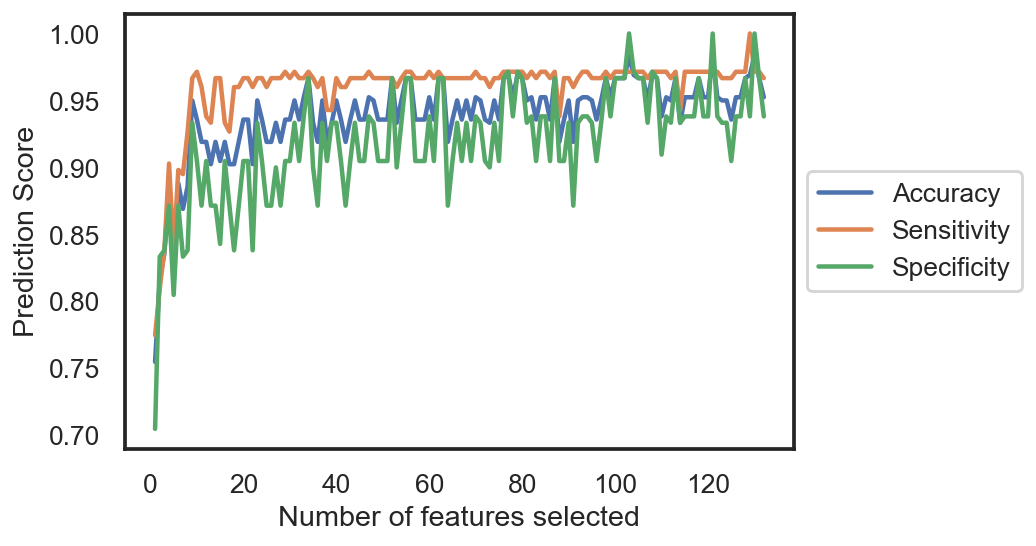

In [283]:
# Create the RFE object and compute a cross-validated score.
#RF= RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, class_weight="balanced",  random_state=42)
RF=RandomForestClassifier(n_estimators=100, random_state=42)


# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# The "accuracy" scoring is proportional to the number of correct
# classifications
accuracy = RFECV(estimator=RF, cv=rsk, scoring='accuracy') #'accuracy'
precision = RFECV(estimator=RF, cv=rsk, scoring='precision') #'accuracy'
recall = RFECV(estimator=RF, cv=rsk, scoring='recall') #'accuracy'

accuracy.fit(X, y)
precision.fit(X, y)
recall.fit(X,y)

print("Optimal number of features : %d" % accuracy.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Prediction Score")
plt.plot(range(1, len(accuracy.grid_scores_) + 1), 
         accuracy.grid_scores_, label='Accuracy')
plt.plot(range(1, len(precision.grid_scores_) + 1), 
         precision.grid_scores_, label='Sensitivity')
plt.plot(range(1, len(recall.grid_scores_) + 1), 
         recall.grid_scores_, label='Specificity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [284]:
print ("The highest accuracy features is {}%" .format(max(accuracy.grid_scores_)*100))

The highest accuracy features is 98.33333333333331%


Rank features by the features importance from `RF-RFECV` algorithms. 

In [285]:
list_of_tuples = list(zip(MLfeatures.columns, 
                          accuracy.estimator_.feature_importances_, 
                          accuracy.support_, accuracy.ranking_))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance', 
                                                  'Selected', 'Ranking'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head(20)

,Metabolites,Importance,Selected,Ranking
1,3872,0.067131,True,1
2,3675,0.051305,True,1
66,2809,0.050428,False,25
5,4080,0.046002,True,1
58,2577,0.043519,True,1
4,6261,0.035327,True,1
7,3804,0.033225,True,1
11,3141,0.030105,True,1
0,2102,0.028605,True,1
61,5110,0.021525,False,26


_Select the features with the top 20 RF feature importance score or all features selected by the RFECV-RF_

In order to use the top features with the lowest q-values, use the the `stat_sig` dataframes

In [286]:
RFfeatures = NMRMS[df_feat['Metabolites'][:20].tolist()] # top 20 ML features
#MLfeatures = NMRMS[df_feat['Metabolites'].tolist()] # all selected features from RFECV-RF
#MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

#### Converge the PLS-DA and RF features.

In [287]:
PLSfeatures.columns

Index([2102, 3872,  720, 3675, 4080, 6261, 6262, 3804,  819, 1701, 5887, 3141,
       1481, 6095, 2455, 3526,  278, 7087, 2850, 4766],
      dtype='object')

In [288]:
RFfeatures.columns

Index([3872, 3675, 2809, 4080, 2577, 6261, 3804, 3141, 2102, 5110, 3160, 1771,
       1481,  720, 6389, 5507, 2005, 6262, 6385, 4408],
      dtype='object')

In [289]:
final_features = set(PLSfeatures) - (set(PLSfeatures) - set(RFfeatures))

In [290]:
final_features

{720, 1481, 2102, 3141, 3675, 3804, 3872, 4080, 6261, 6262}

In [291]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [292]:
MS_labels[MS_labels.ID.isin(final_features)]

,ID,Mode,RT [min],Name,Formula
719,720,positive,2.562,2-Aminoacetophenone;O-Acetylaniline,C8 H9 N O
1480,1481,positive,6.290,1481,NaN
2101,2102,positive,3.449,"N,N-Diisopropylethylamine (DIPEA)",C8 H19 N
3140,3141,positive,1.133,3141,C7 H18 N8 O6 S
3674,3675,positive,1.184,3675,NaN
3803,3804,positive,2.595,3804,C4 H12 N O6 P
3871,3872,positive,4.049,3872,NaN
4079,4080,positive,0.821,4080,C10 H21 N3 O8 P2 S
6260,6261,negative,2.591,6261,C9 H18 N9 O2 P
6261,6262,negative,2.667,6262,C10 H20 N9 O5 P


In [294]:
MLfeatures = NMRMS[list(final_features)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

### c. Machine Learning for RCC Prediction

_Machine Learning Model Function_

In [295]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    
    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    AUC, ACC, PRE, REC, FS, MCC = [], [], [], [], [], [] # define 'list' of various metrics
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
    return AUC, ACC, PRE, REC, FS, MCC

_Machine Learning Metric Plot Function_

In [296]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)



Define features and labels.

In [297]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures.values
y = dfgroup.values

### Grid Search: Random Forest

[Method Reference: towardsdatascience.com](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) <br>
[GridSearchCV sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [298]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)

# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = rsk, scoring = 'accuracy', n_jobs = -1, verbose = 2)

In [299]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.8min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [126]:
grid_search.best_score_

0.9354838709677419

In [25]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.067116,0.006247,0.006401,0.000815,True,1,1,1,2,50,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.785714,1.0,0.916667,0.916667,0.916667,0.903226,0.070963,527
1,0.118734,0.004807,0.014127,0.004409,True,1,1,1,2,100,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.857143,1.0,1.000000,1.000000,0.916667,0.951613,0.060092,48
2,0.175238,0.002607,0.015989,0.001169,True,1,1,1,2,150,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.928571,1.0,1.000000,1.000000,0.916667,0.967742,0.038152,1
3,0.230870,0.001262,0.021666,0.000785,True,1,1,1,2,200,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.857143,1.0,1.000000,1.000000,0.916667,0.951613,0.060092,48
4,0.058671,0.001442,0.006905,0.001125,True,1,1,1,4,50,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.785714,1.0,0.916667,0.916667,0.916667,0.903226,0.070963,527
5,0.116687,0.005042,0.012410,0.001433,True,1,1,1,4,100,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.857143,1.0,1.000000,1.000000,0.916667,0.951613,0.060092,48
6,0.173279,0.004011,0.016601,0.000619,True,1,1,1,4,150,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.928571,1.0,1.000000,1.000000,0.916667,0.967742,0.038152,1
7,0.243259,0.005736,0.025047,0.003505,True,1,1,1,4,200,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.857143,1.0,1.000000,1.000000,0.916667,0.951613,0.060092,48
8,0.060181,0.005166,0.005979,0.000388,True,1,1,1,6,50,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.785714,1.0,0.916667,0.916667,0.916667,0.903226,0.070963,527
9,0.121514,0.003933,0.011089,0.000405,True,1,1,1,6,100,"{'bootstrap': True, 'max_depth': 1, 'max_featu...",0.857143,1.0,1.000000,1.000000,0.916667,0.951613,0.060092,48


### Grid Search: SVM-RBF

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100],
         'gamma': [0.001, 0.01, 0.03, 0.1, 0.3, 1.0]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [50]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    0.2s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [51]:
grid_search.best_score_

1.0

In [35]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000677,0.000138,0.000376,0.000094,1e-05,0.001,rbf,"{'C': 1e-05, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,0.916667,0.666667,0.833333,0.750000,0.838710,0.119616,19
1,0.000835,0.000132,0.000459,0.000050,1e-05,0.01,rbf,"{'C': 1e-05, 'gamma': 0.01, 'kernel': 'rbf'}",1.000000,0.916667,0.916667,1.000000,1.000000,0.967742,0.040591,1
2,0.000608,0.000074,0.000414,0.000128,1e-05,0.03,rbf,"{'C': 1e-05, 'gamma': 0.03, 'kernel': 'rbf'}",0.928571,1.000000,1.000000,0.916667,1.000000,0.967742,0.038152,1
3,0.000756,0.000073,0.000460,0.000026,1e-05,0.1,rbf,"{'C': 1e-05, 'gamma': 0.1, 'kernel': 'rbf'}",0.857143,0.916667,1.000000,0.833333,0.916667,0.903226,0.057511,13
4,0.000671,0.000081,0.000408,0.000018,1e-05,0.3,rbf,"{'C': 1e-05, 'gamma': 0.3, 'kernel': 'rbf'}",0.857143,0.666667,0.750000,0.833333,0.750000,0.774194,0.068520,25
5,0.000769,0.000173,0.000437,0.000089,1e-05,1,rbf,"{'C': 1e-05, 'gamma': 1.0, 'kernel': 'rbf'}",0.714286,0.583333,0.583333,0.500000,0.666667,0.612903,0.075406,31
6,0.001274,0.001050,0.000475,0.000087,1e-05,0.001,rbf,"{'C': 1e-05, 'gamma': 0.001, 'kernel': 'rbf'}",1.000000,0.916667,0.666667,0.833333,0.750000,0.838710,0.119616,19
7,0.000723,0.000100,0.000514,0.000083,1e-05,0.01,rbf,"{'C': 1e-05, 'gamma': 0.01, 'kernel': 'rbf'}",1.000000,0.916667,0.916667,1.000000,1.000000,0.967742,0.040591,1
8,0.000773,0.000242,0.001229,0.001446,1e-05,0.03,rbf,"{'C': 1e-05, 'gamma': 0.03, 'kernel': 'rbf'}",0.928571,1.000000,1.000000,0.916667,1.000000,0.967742,0.038152,1
9,0.001145,0.000965,0.000485,0.000124,1e-05,0.1,rbf,"{'C': 1e-05, 'gamma': 0.1, 'kernel': 'rbf'}",0.857143,0.916667,1.000000,0.833333,0.916667,0.903226,0.057511,13


### Grid Search: Lin-SVM

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 5, 10.]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [37]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.1s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



{'C': 1, 'kernel': 'linear'}

In [38]:
grid_search.best_score_

1.0

In [39]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000890,0.000164,0.000449,0.000047,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",1.000000,0.916667,0.583333,0.833333,0.75,0.822581,0.144713,6
1,0.000758,0.000039,0.000441,0.000077,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.928571,1.000000,1.000000,1.000000,1.00,0.983871,0.029865,4
2,0.000679,0.000024,0.000430,0.000049,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.928571,1.000000,1.000000,1.000000,1.00,0.983871,0.029865,4
3,0.000779,0.000167,0.000473,0.000153,1,linear,"{'C': 1, 'kernel': 'linear'}",1.000000,1.000000,1.000000,1.000000,1.00,1.000000,0.000000,1
4,0.000812,0.000231,0.000446,0.000106,5,linear,"{'C': 5, 'kernel': 'linear'}",1.000000,1.000000,1.000000,1.000000,1.00,1.000000,0.000000,1
5,0.000620,0.000050,0.000376,0.000044,10,linear,"{'C': 10.0, 'kernel': 'linear'}",1.000000,1.000000,1.000000,1.000000,1.00,1.000000,0.000000,1


### Grid Search: kNN

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(1,30)), 'p': [1,2]}

knn_cls = KNeighborsClassifier()
              
grid_search = GridSearchCV(knn_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [41]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 58 candidates, totalling 290 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 290 out of 290 | elapsed:    0.4s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



{'n_neighbors': 4, 'p': 1}

In [42]:
grid_search.best_score_

0.967741935483871

In [43]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001291,0.001292,0.001505,0.000485,1,1,"{'n_neighbors': 1, 'p': 1}",1.000000,0.916667,0.916667,0.833333,1.000000,0.935484,0.062467,10
1,0.000641,0.000120,0.001515,0.000298,1,2,"{'n_neighbors': 1, 'p': 2}",0.928571,0.916667,1.000000,0.833333,1.000000,0.935484,0.060911,10
2,0.000626,0.000195,0.001406,0.000344,2,1,"{'n_neighbors': 2, 'p': 1}",1.000000,0.916667,1.000000,0.833333,1.000000,0.951613,0.066175,3
3,0.000637,0.000089,0.001924,0.000322,2,2,"{'n_neighbors': 2, 'p': 2}",0.928571,0.916667,1.000000,0.833333,1.000000,0.935484,0.060911,10
4,0.000633,0.000037,0.002017,0.000255,3,1,"{'n_neighbors': 3, 'p': 1}",1.000000,0.916667,1.000000,0.833333,1.000000,0.951613,0.066175,3
5,0.000628,0.000038,0.001879,0.000424,3,2,"{'n_neighbors': 3, 'p': 2}",1.000000,0.916667,1.000000,0.833333,1.000000,0.951613,0.066175,3
6,0.001040,0.000819,0.006695,0.009134,4,1,"{'n_neighbors': 4, 'p': 1}",1.000000,0.916667,1.000000,0.916667,1.000000,0.967742,0.040591,1
7,0.000703,0.000222,0.001795,0.000227,4,2,"{'n_neighbors': 4, 'p': 2}",1.000000,0.916667,1.000000,0.916667,1.000000,0.967742,0.040591,1
8,0.000605,0.000034,0.001641,0.000091,5,1,"{'n_neighbors': 5, 'p': 1}",1.000000,0.916667,1.000000,0.916667,0.916667,0.951613,0.041121,3
9,0.000573,0.000109,0.002584,0.001734,5,2,"{'n_neighbors': 5, 'p': 2}",1.000000,0.916667,1.000000,0.833333,1.000000,0.951613,0.066175,3


### Train Machine Learning Models.

In [169]:
# Random Forest

#RF=RandomForestClassifier(n_estimators=100, random_state=123)
RF=RandomForestClassifier(n_estimators=100, min_samples_split=4, 
                          min_samples_leaf=1, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]


# Linear-SVM
linsvm = svm.SVC(C = 1, kernel = 'linear', probability=True, random_state=42)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]


# SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(C = 10, gamma = 0.01, kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]

# KNN
knn = KNeighborsClassifier(n_neighbors=4, p=1)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]



#Others....

# Bagging
BAG=BaggingClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, BAG)
BAG_AUC, BAG_ACC, BAG_PRE, BAG_REC, BAG_FS, BAG_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]
# Gradient Boosting
GBC=GradientBoostingClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, GBC)
GBC_AUC, GBC_ACC, GBC_PRE, GBC_REC, GBC_FS, GBC_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]

**AUC**

In [170]:
sns.set_context('talk', font_scale=0.8)

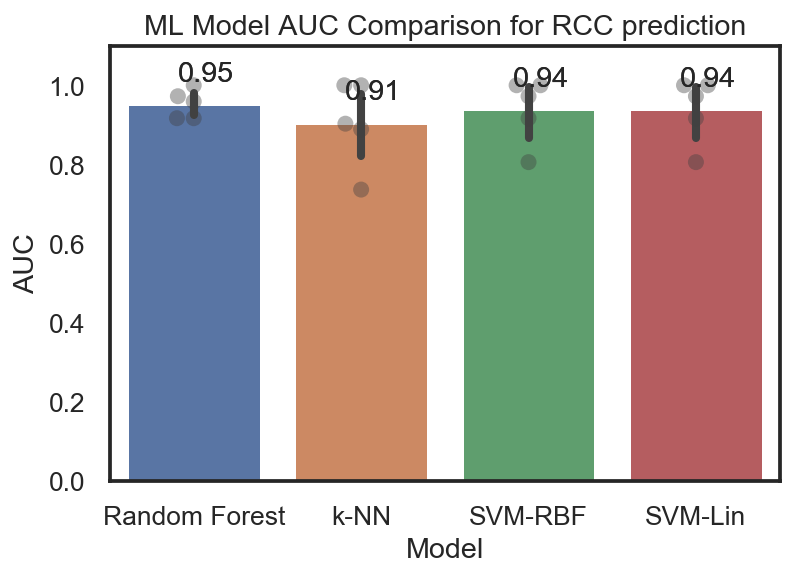

In [171]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
plt.title('ML Model AUC Comparison for RCC prediction');

**Accuracy**

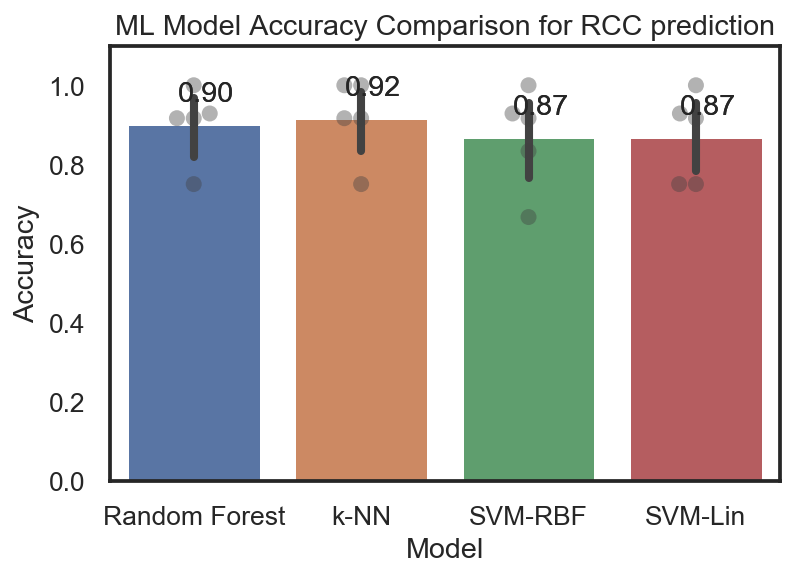

In [172]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
plt.title('ML Model Accuracy Comparison for RCC prediction');

**Precision**

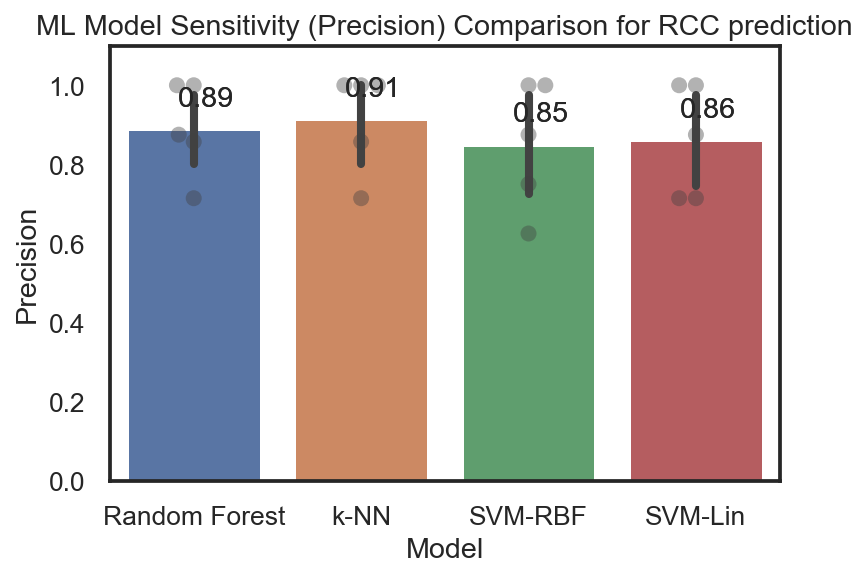

In [173]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

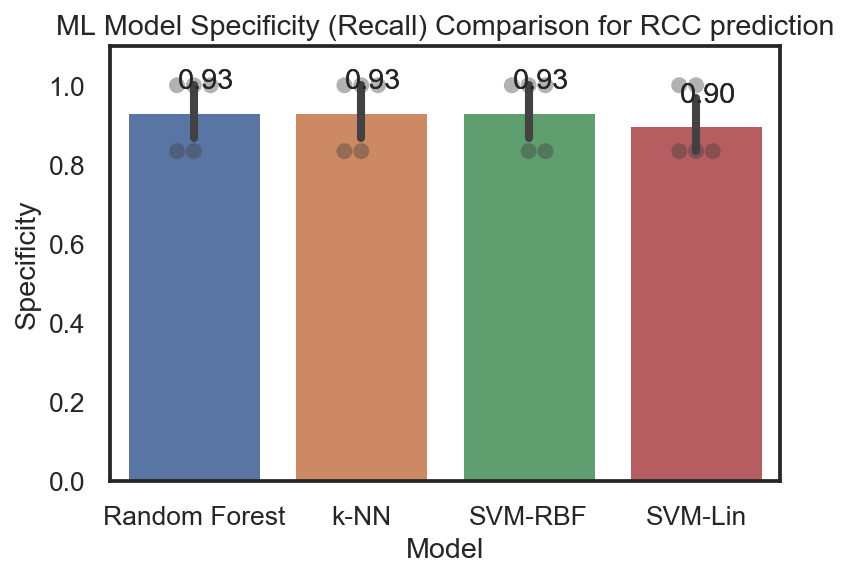

In [174]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Specificity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Specificity');
plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

**F1 Score**

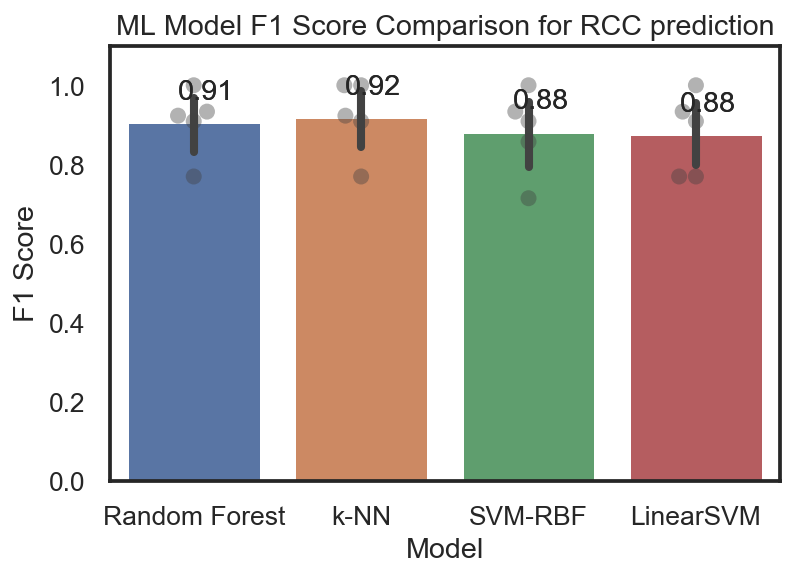

In [175]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
plt.title('ML Model F1 Score Comparison for RCC prediction');

### Chemical Information of the Biomarkers

In [176]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [177]:
MS_labels[MS_labels.ID.isin(MLfeatures.columns)]

,ID,Mode,RT [min],Name,Formula
277,278,positive,3.057,278,NaN
719,720,positive,2.562,2-Aminoacetophenone;O-Acetylaniline,C8 H9 N O
1700,1701,positive,1.807,4-(2-Aminoethyl)benzenesulfonylfluoride,C8 H10 F N O2 S
2454,2455,positive,1.140,2455,C8 H11 N3 S
3803,3804,positive,2.595,3804,C4 H12 N O6 P
4765,4766,negative,1.432,Theophylline,C7 H8 N4 O2


An alternative way to plot the feature importance/

feature_imp = pd.DataFrame({'Features': MLfeatures.columns, 
                           'Importance': RF.feature_importances_})
feature_imp.sort_values(by='Importance', ascending=True, inplace=True);
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp['Features'], 
            y=feature_imp['Importance']);

In [178]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


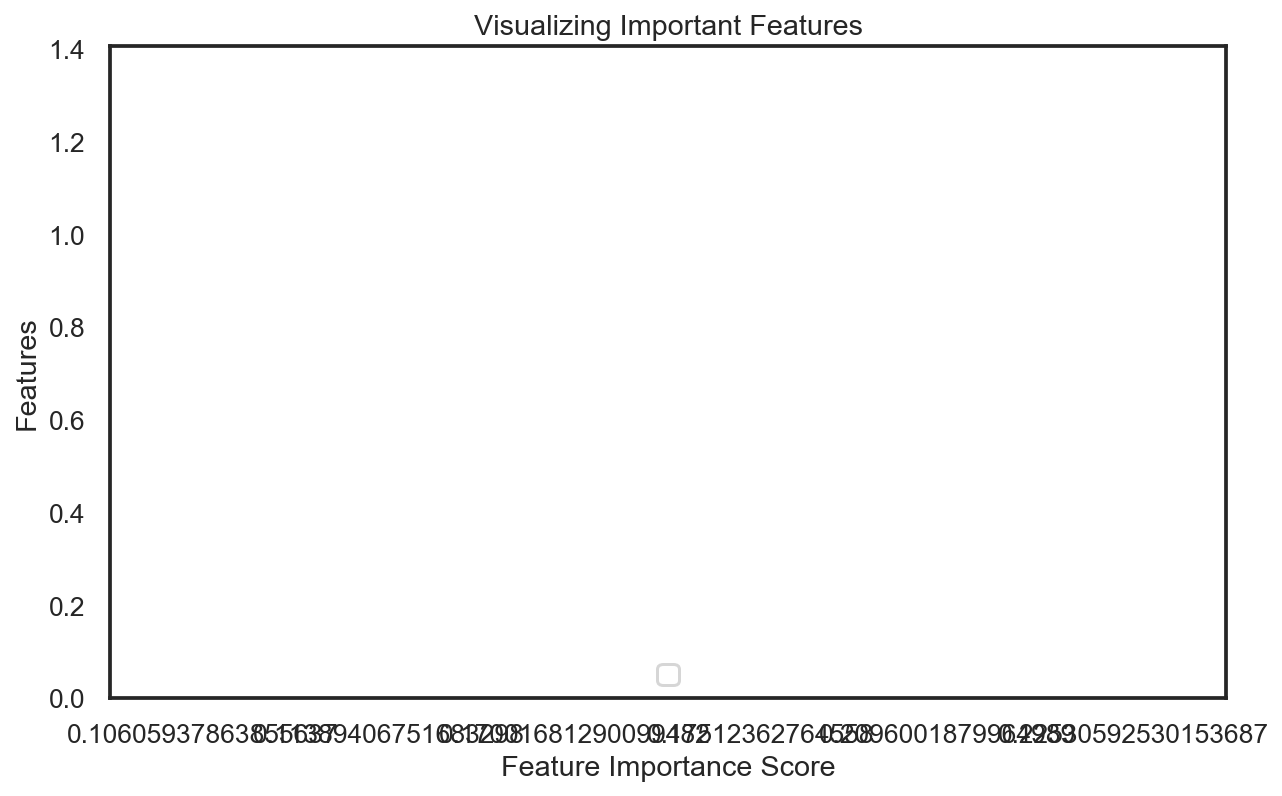

In [179]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### d. Potential Biomarkers: PCA, HCA, Boxplot Visualization

In [180]:
#biomarker_feat = dummydf[df_feat['Metabolites']]
#biomarker_feat =(biomarker_feat - biomarker_feat.mean(axis=0))/biomarker_feat.std(axis=0)
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

_Rename column in biomarker dataframe to reduce length of feature name_

In [181]:
biomarker.rename(columns={'4-(2-Aminoethyl)benzenesulfonylfluoride':'AEBSF',
                          'N,N-Diisopropylethylamine (DIPEA)':'DIPEA',
                          '2-Aminoacetophenone;O-Acetylaniline':'O-Acetylaniline'}, 
                 inplace=True)

#### Boxplot

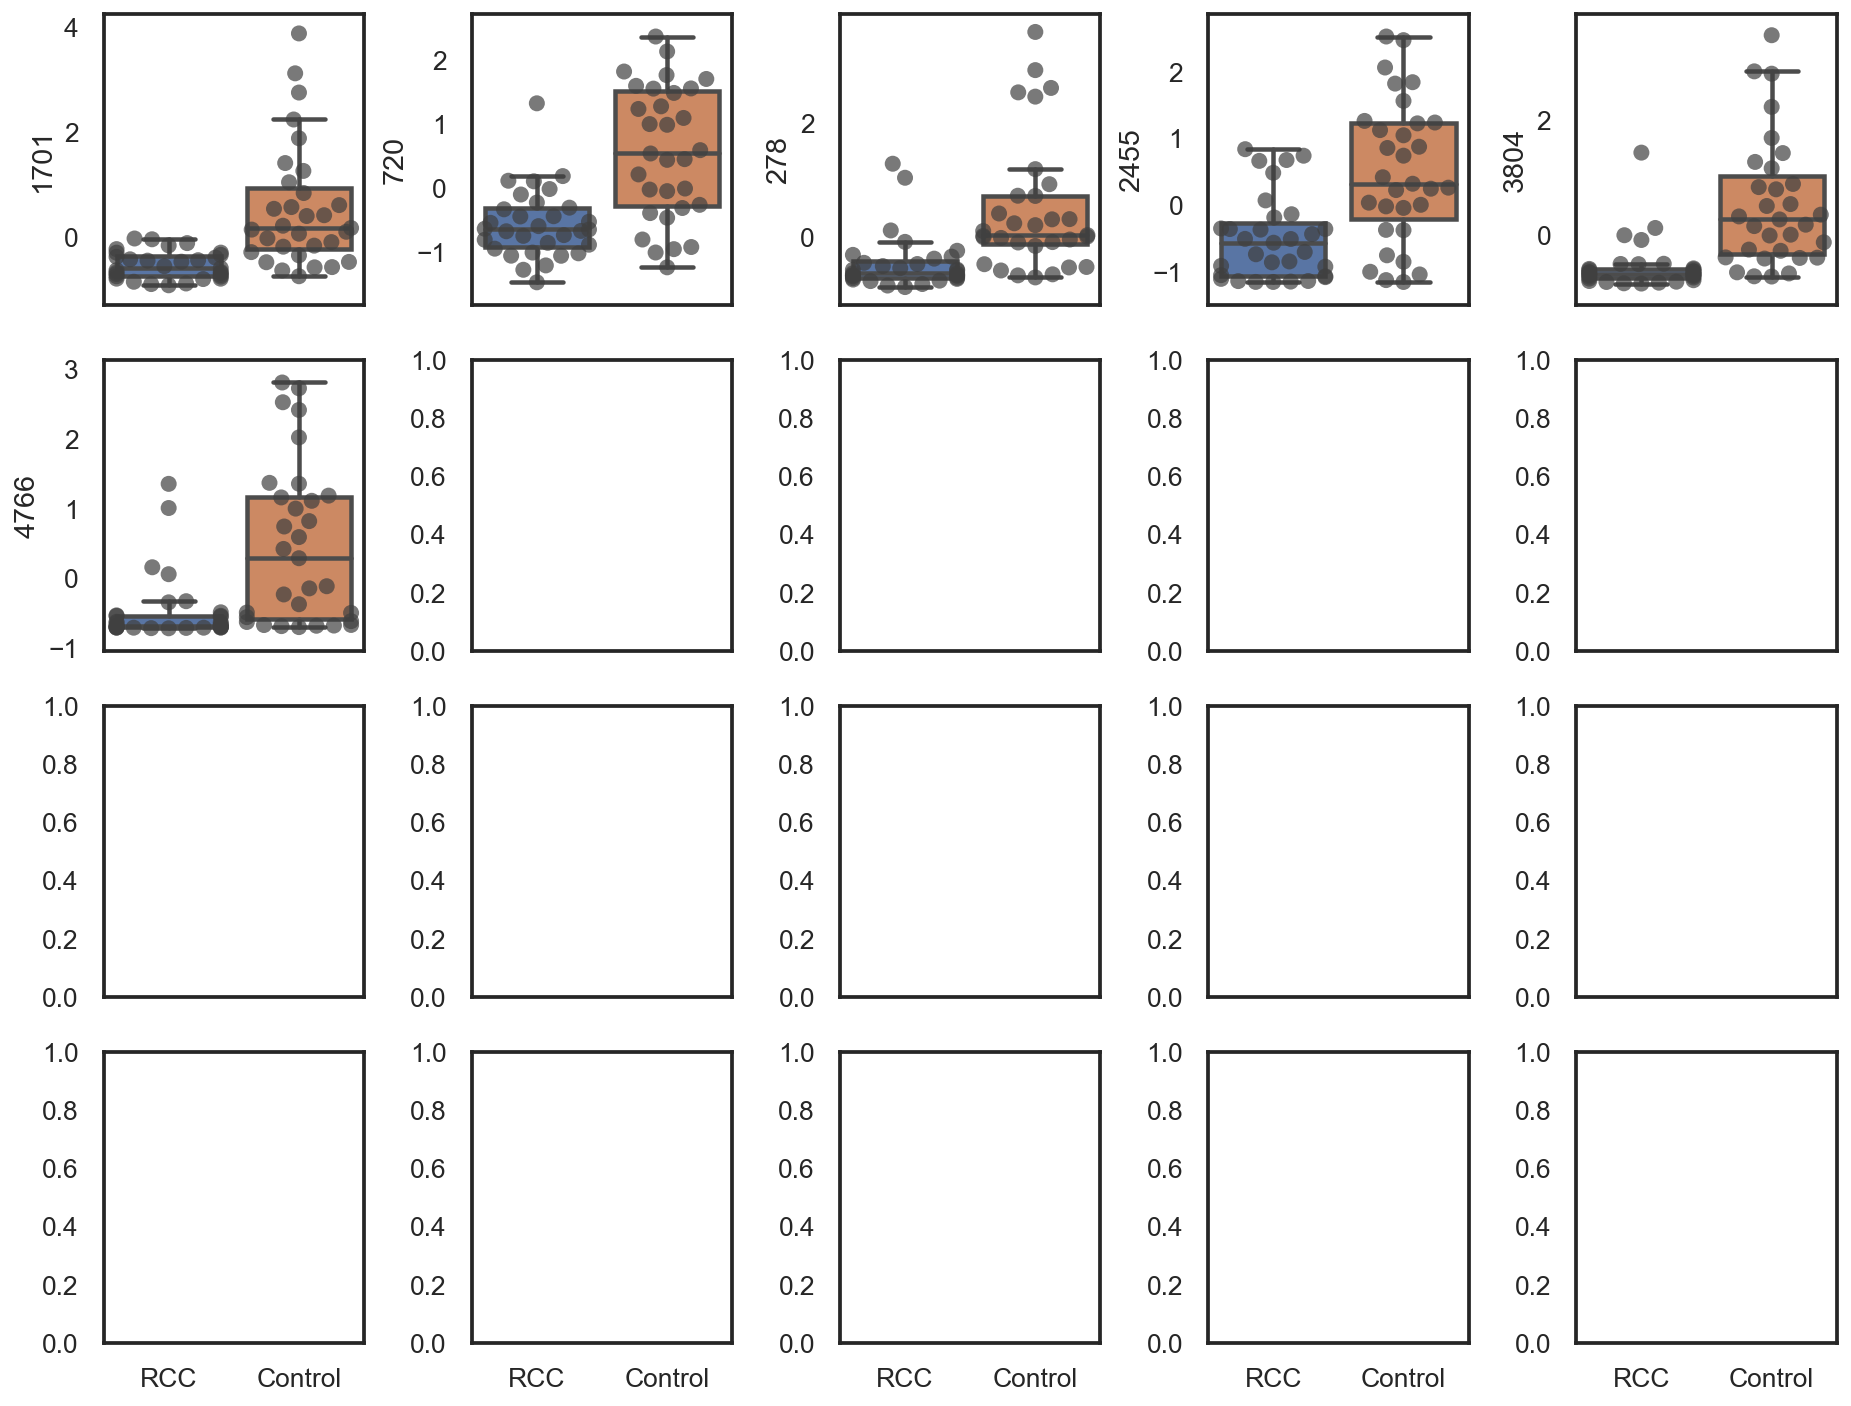

In [182]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(13, 10))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots.svg', dpi=300)

#### PCA

In [183]:
def PCA_Python(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Control');
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label='RCC');
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

PCA score plots using all ML features

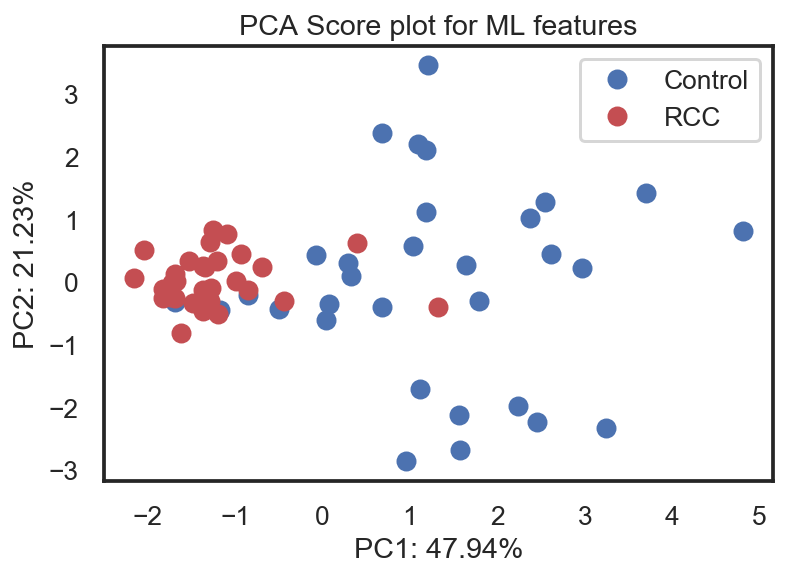

In [184]:
ylabel = biomarker['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [185]:
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

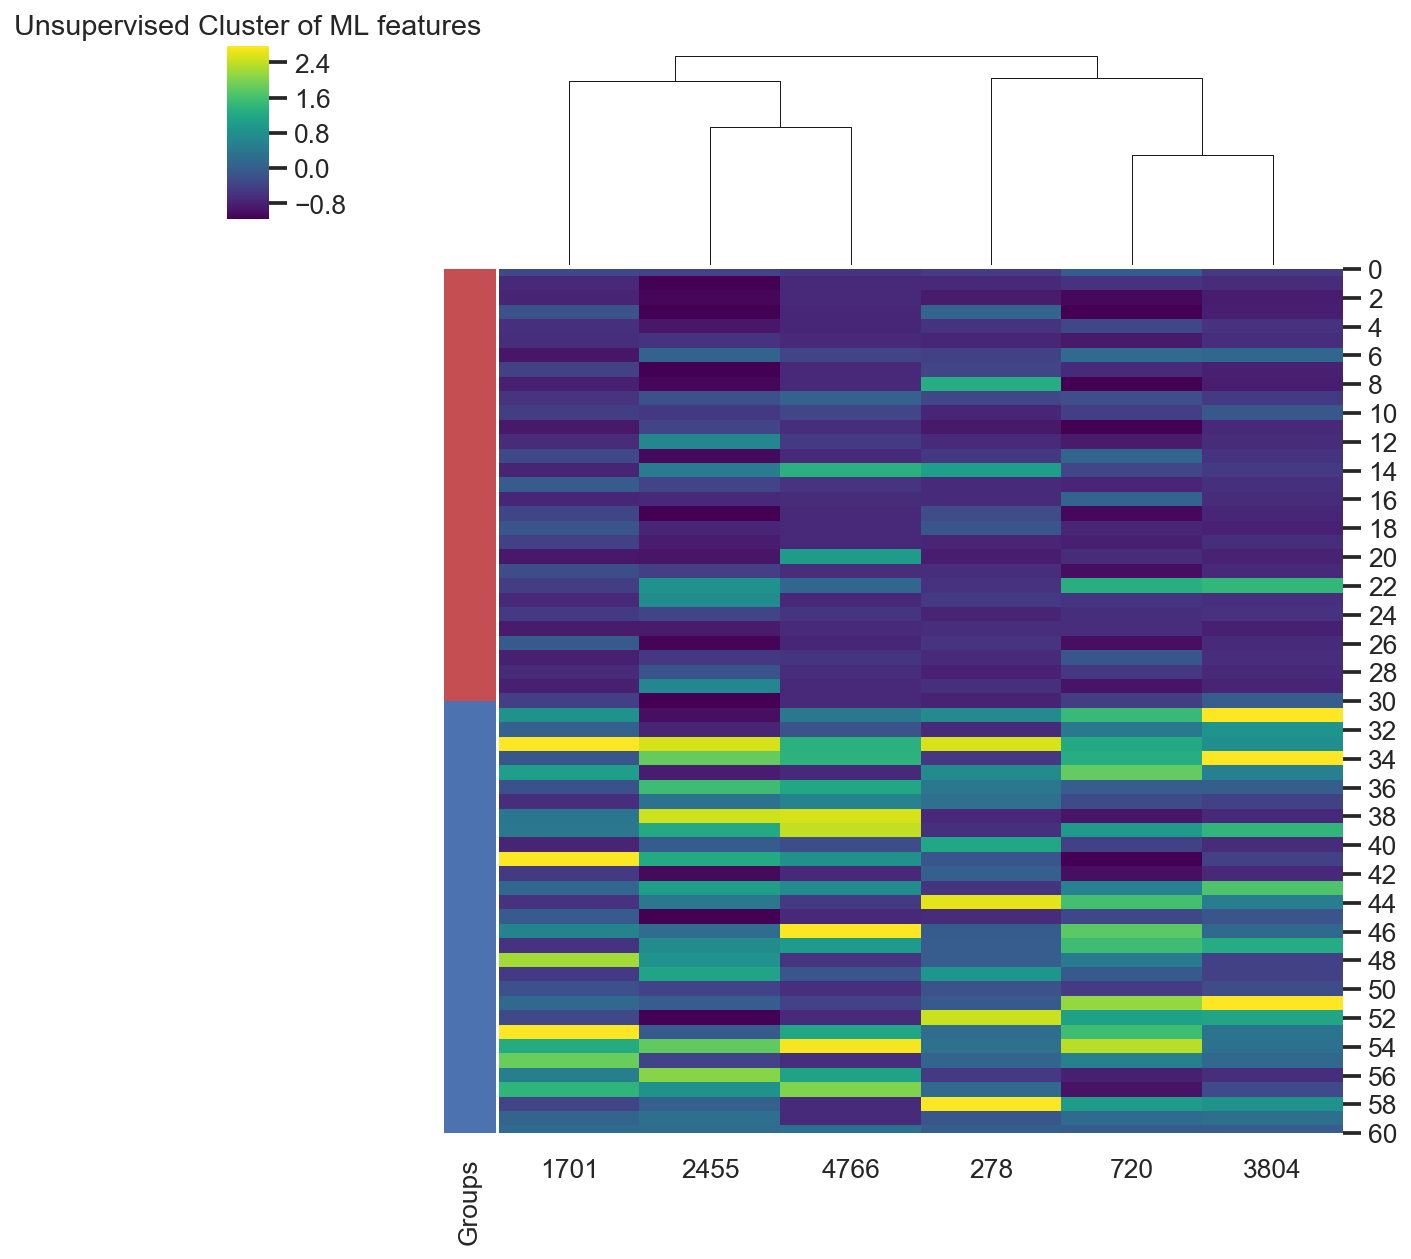

In [186]:
groups_two = biomarker.pop('Groups')
biomarker = biomarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

**Hierarchial Clustering using features with _q_ value < 0.05**

In [187]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
qfeatures = NMRMS[Feature] # p<0.05 metabolites
qfeatures =(qfeatures - qfeatures.mean(axis=0))/qfeatures.std(axis=0) #autoscaling
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)

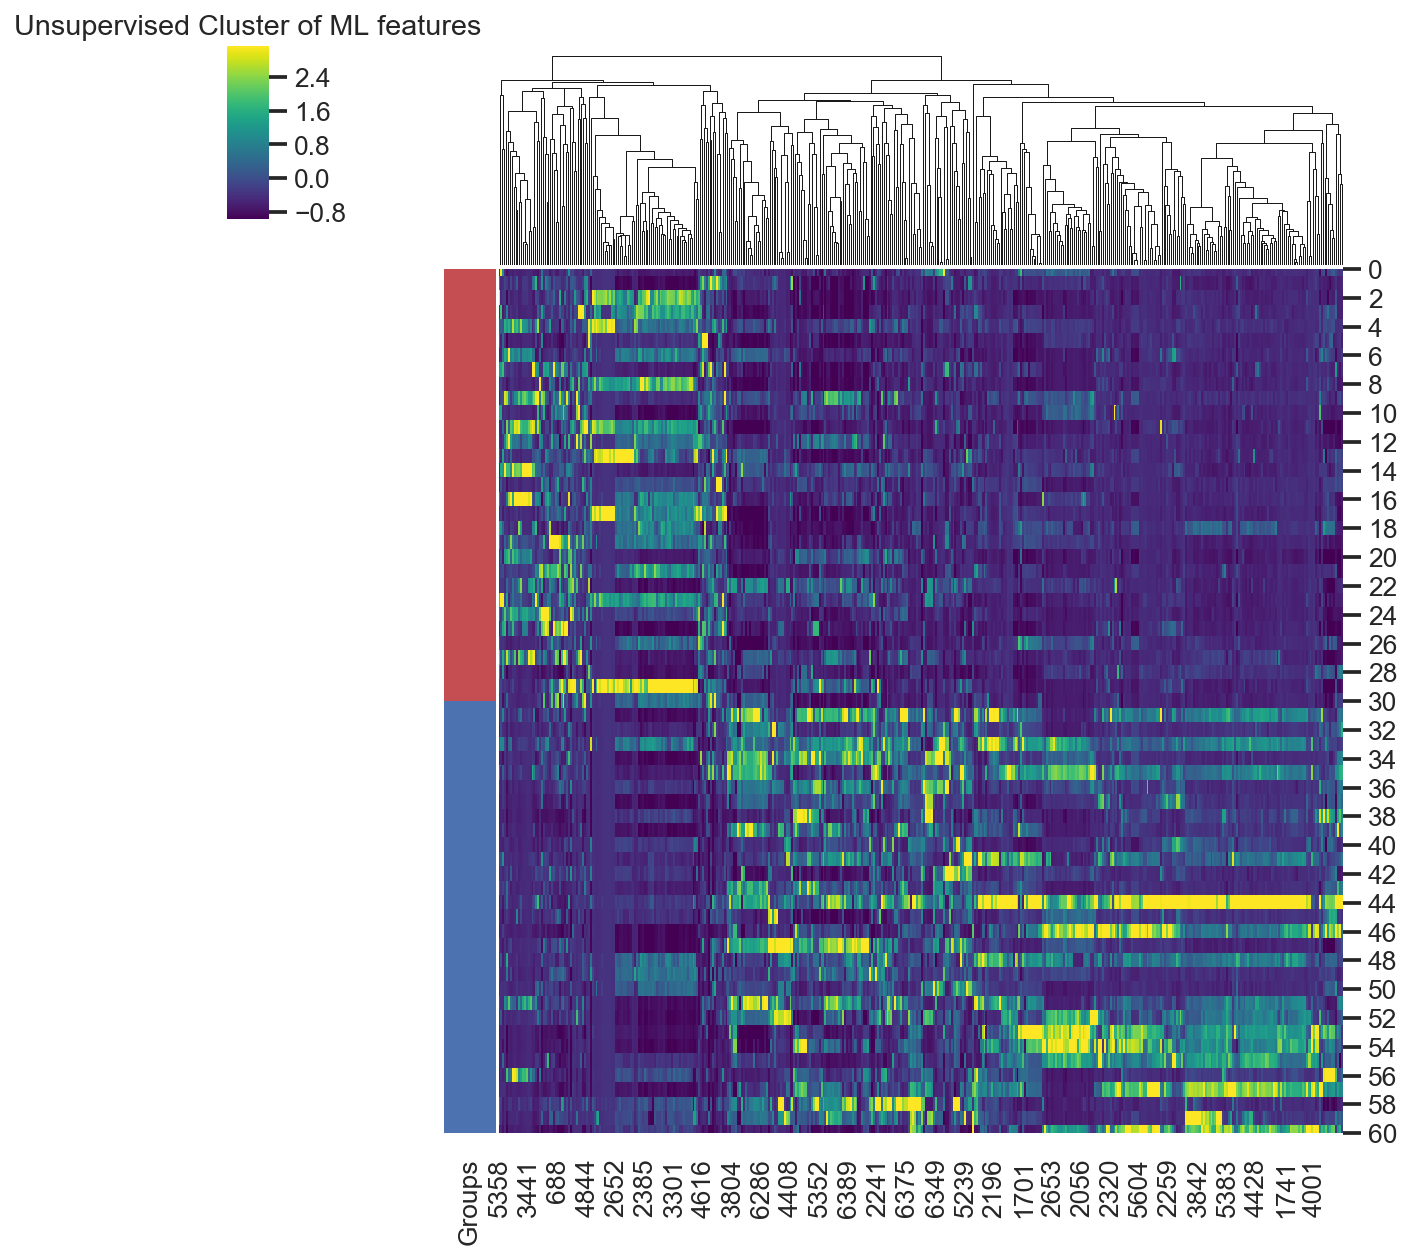

In [188]:
groups_two = qmarker.pop('Groups')
qmarker = qmarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(qmarker, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)

### [Go back to notebook content](#0)

# 2. RCC Prediction: Test Cohort
<a id="2"></a>

In [189]:
testcohort = pd.read_excel('data/testcohort.xlsx')

In [190]:
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
MLfeatures2.shape

(194, 6)

Define features and labels.

In [191]:
dfgrp = testcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures2.values
y = dfgroup.values
print (X.shape)
print (y.shape)

(194, 6)
(194,)


### Call the tuned machine learning algorithms

In [192]:
RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [193]:
linsvm

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [194]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [195]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=1,
                     weights='uniform')

In [196]:
# Random Forest

#RF=RandomForestClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]


# Linear-SVM
#linsvm = svm.SVC(C = 0.01, kernel = 'linear', probability=True)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]


# SVM
#clf = svm.SVC(kernel='linear', probability=True)
#clf = svm.SVC(C = 1.0, gamma = 0.01, kernel = 'rbf', probability=True)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]

# KNN
#knn = KNeighborsClassifier(n_neighbors=3, p=1)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5]


**AUC**

In [197]:
sns.set_context('talk', font_scale=0.8)

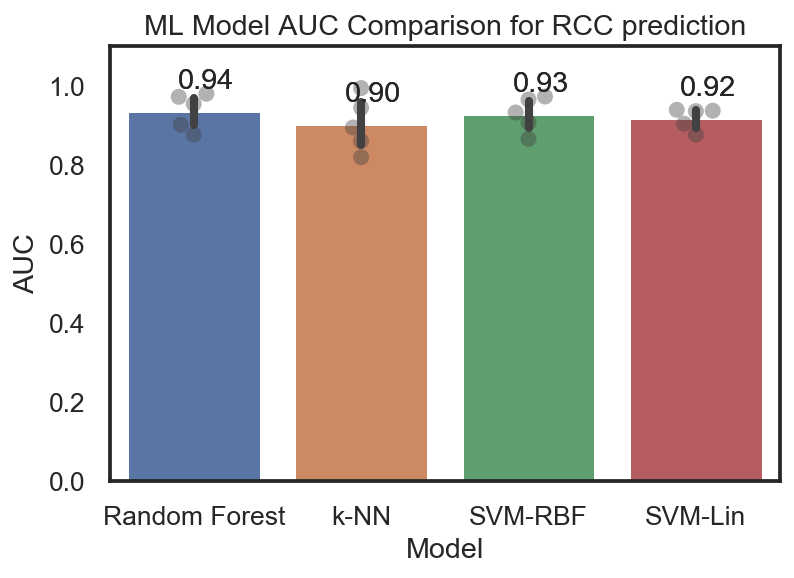

In [198]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
plt.title('ML Model AUC Comparison for RCC prediction');

**Accuracy**

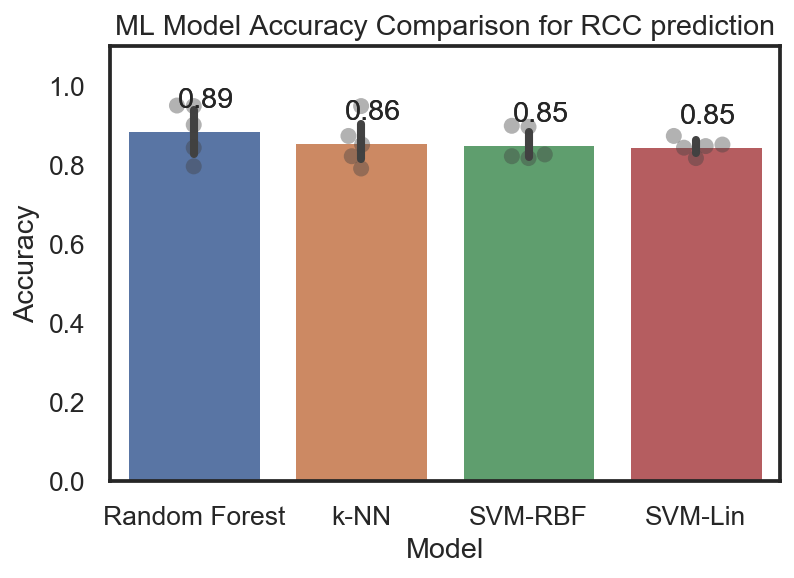

In [199]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
plt.title('ML Model Accuracy Comparison for RCC prediction');

**Precision**

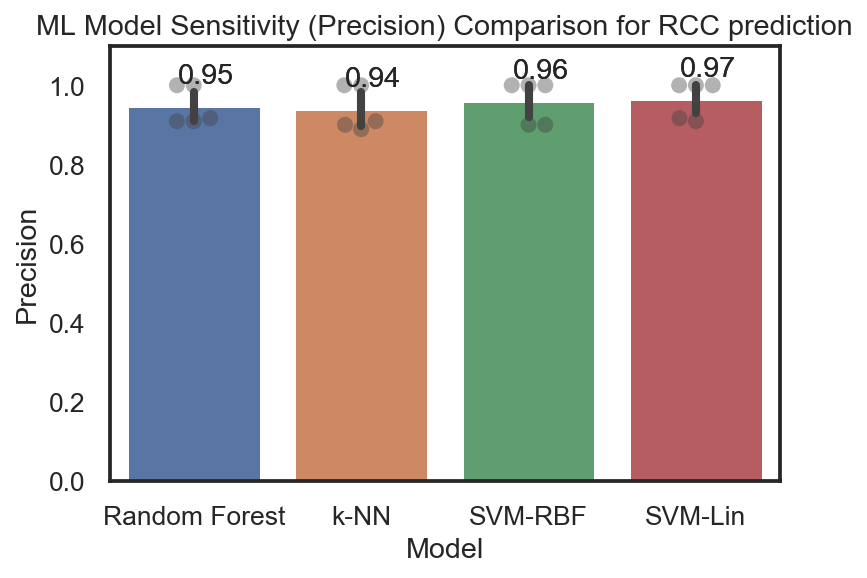

In [120]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

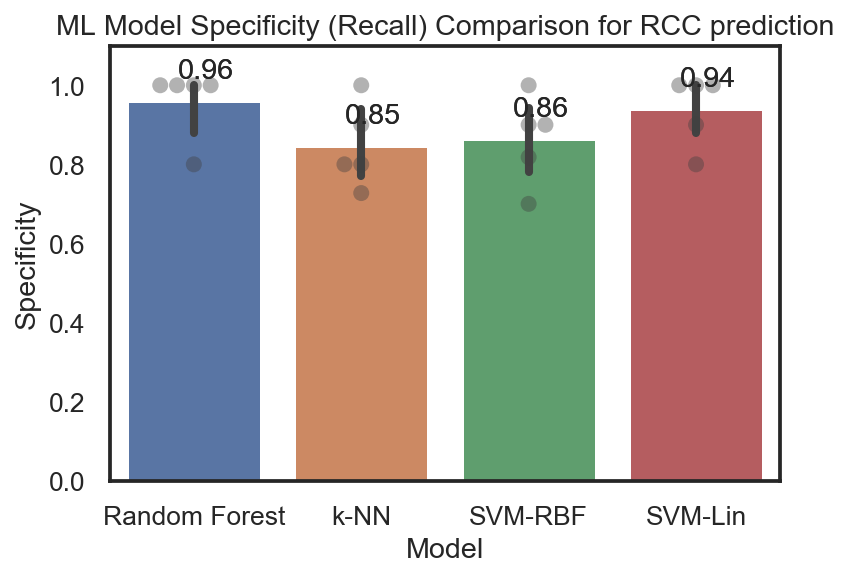

In [121]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Specificity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Specificity');
plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

**F1 Score**

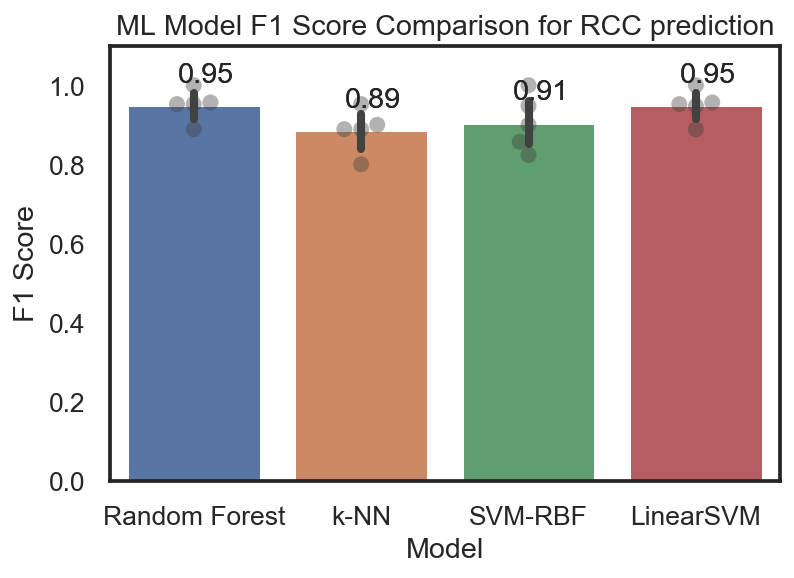

In [122]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
plt.title('ML Model F1 Score Comparison for RCC prediction');

The best classifier is RF, and here are the feature importance from random forest:

In [123]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures2.columns.astype(float)).sort_values(ascending=False)

No handles with labels found to put in legend.


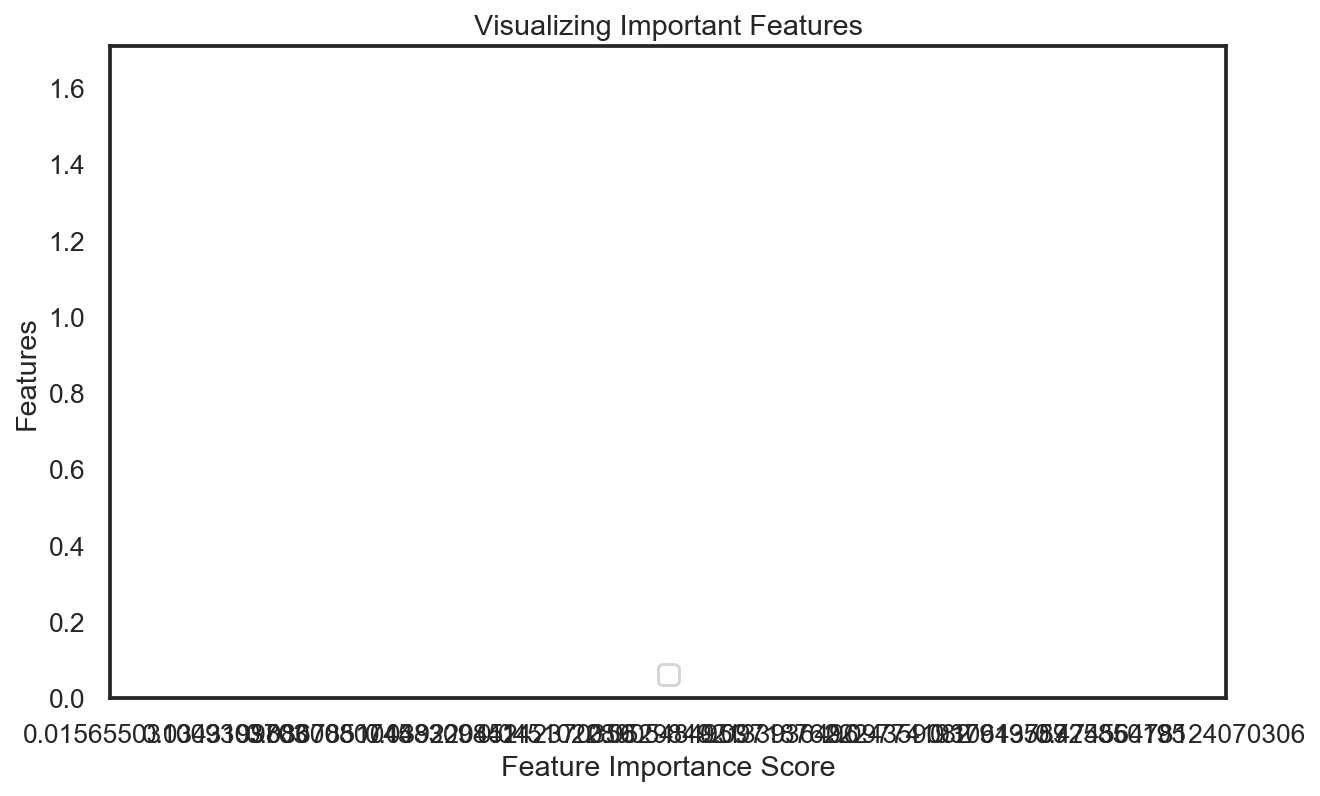

In [124]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Biomarkers: PCA, Hierarchical clustering and Boxplot Visualization

In [125]:
print (testcohort.shape)
print (MLfeatures2.shape)

(194, 7155)
(194, 10)


In [126]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 11)

Boxplot

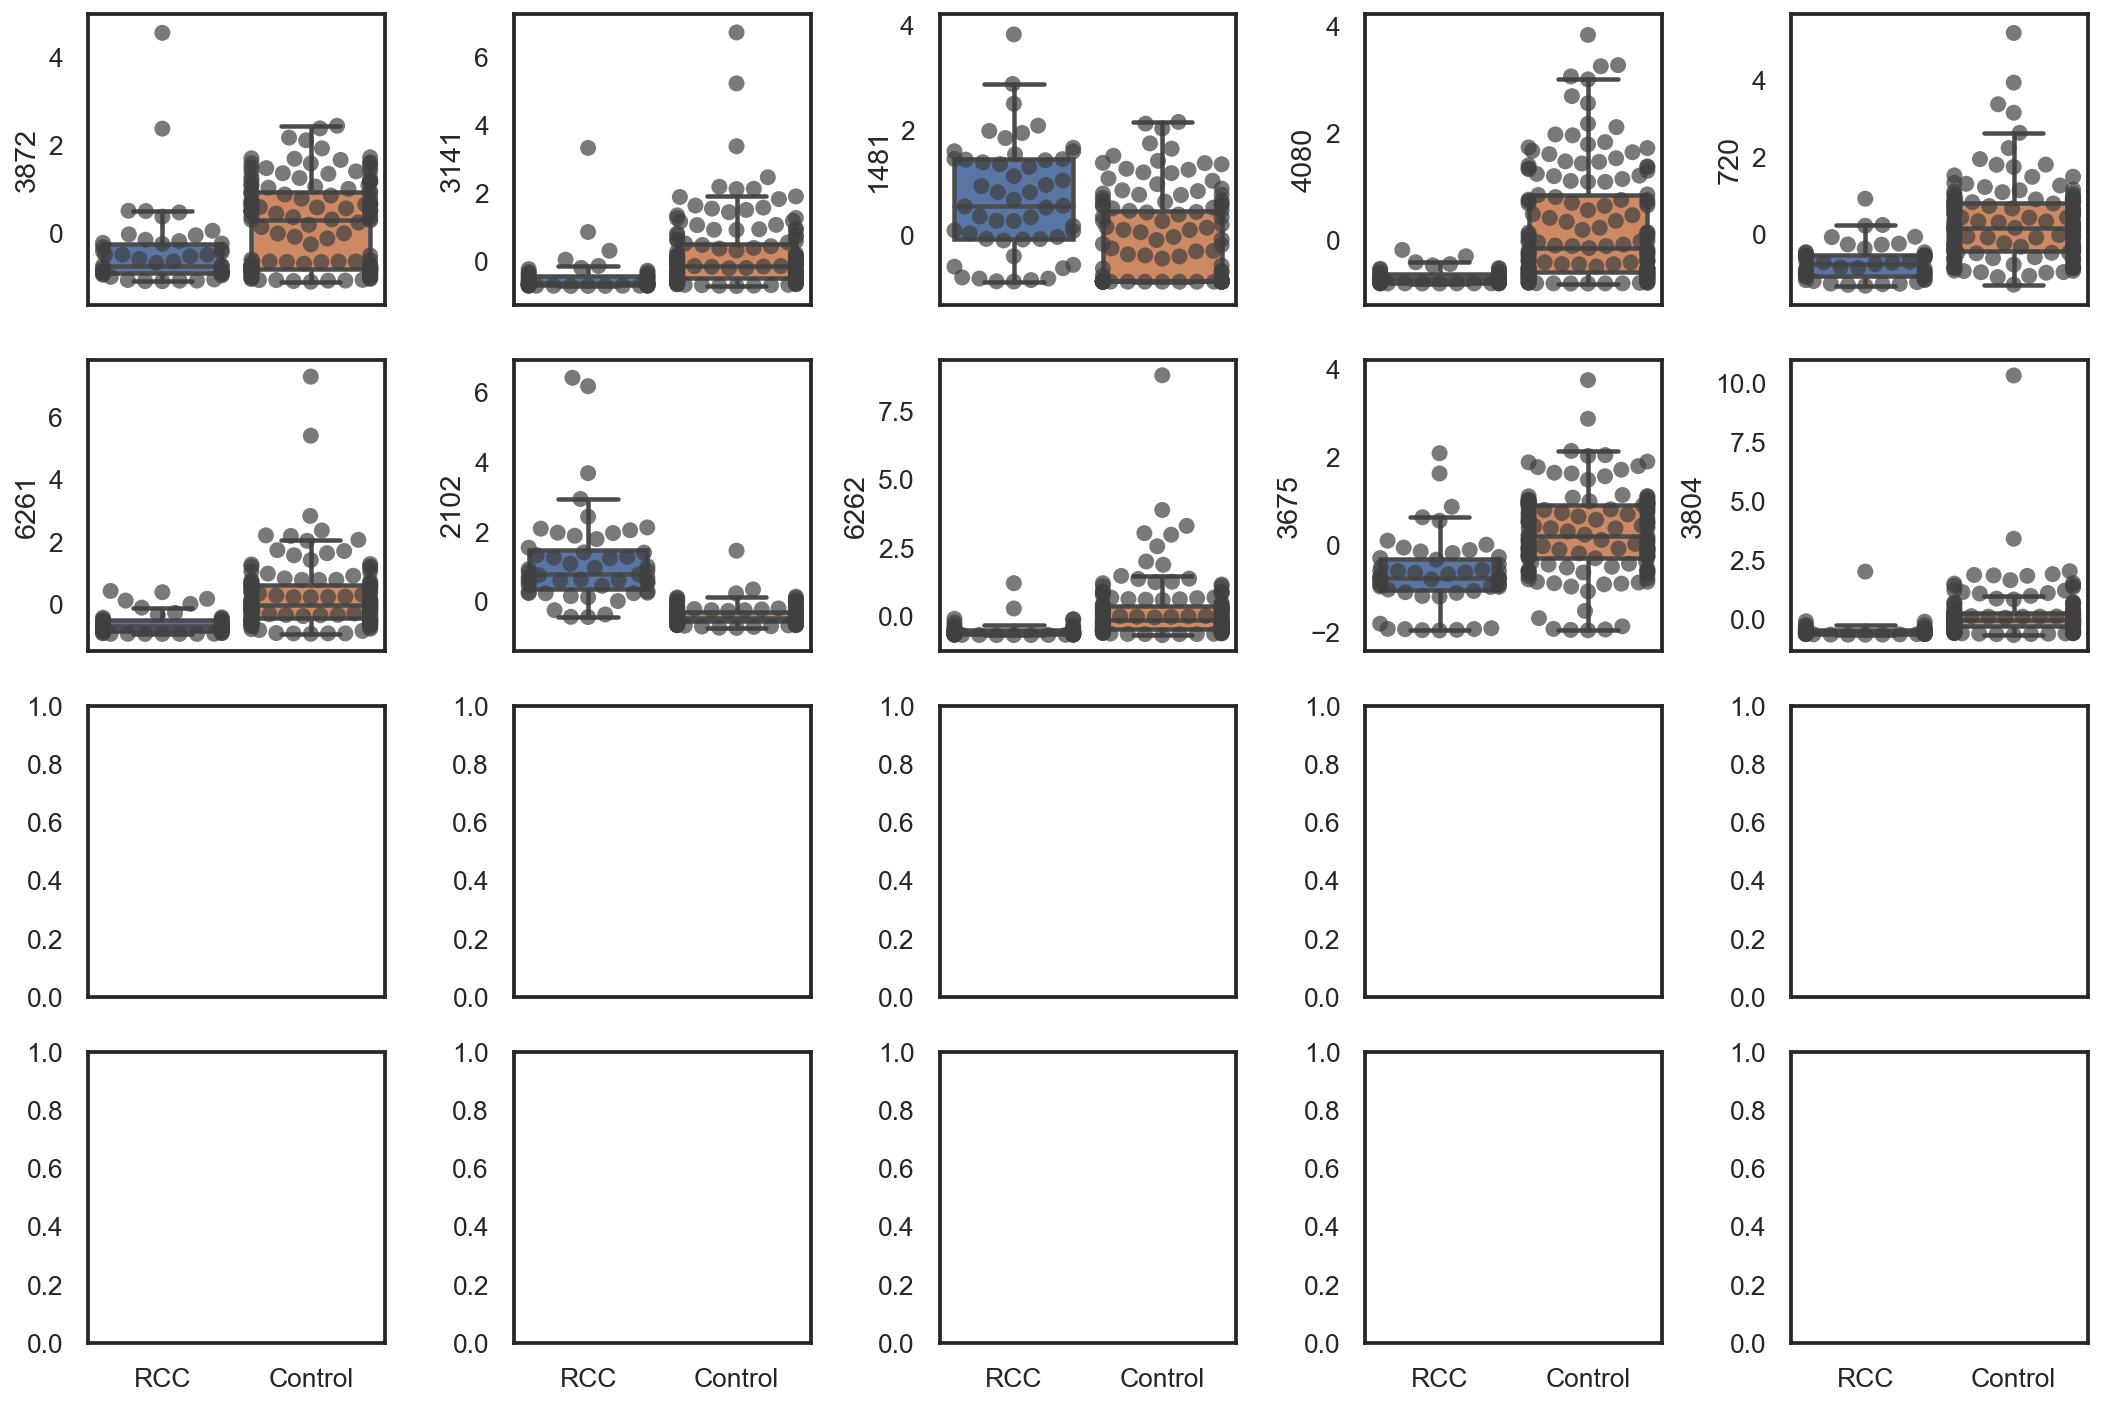

In [127]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(15, 10))
for idx, feat in enumerate(biomarker2.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker2, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker2, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots2.svg', dpi=300)

**PCA score plots using all ML features**

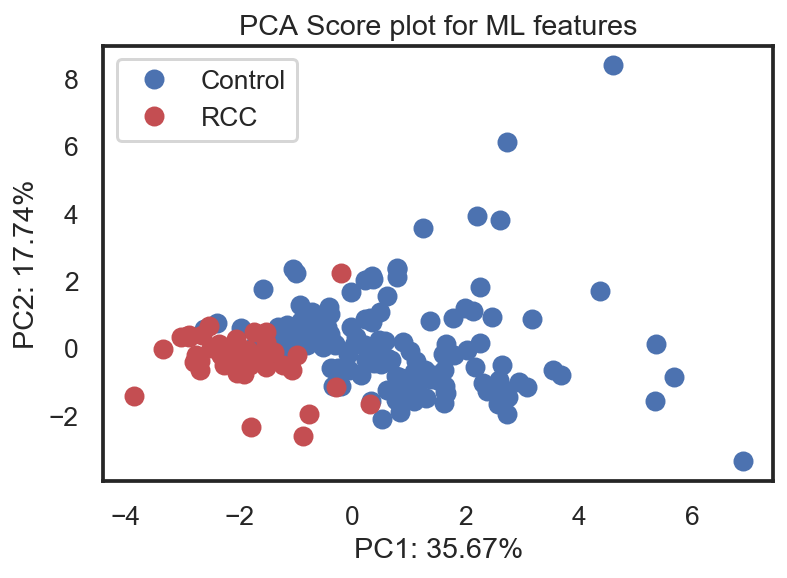

In [128]:
ylabel = biomarker2['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures2, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [129]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 11)

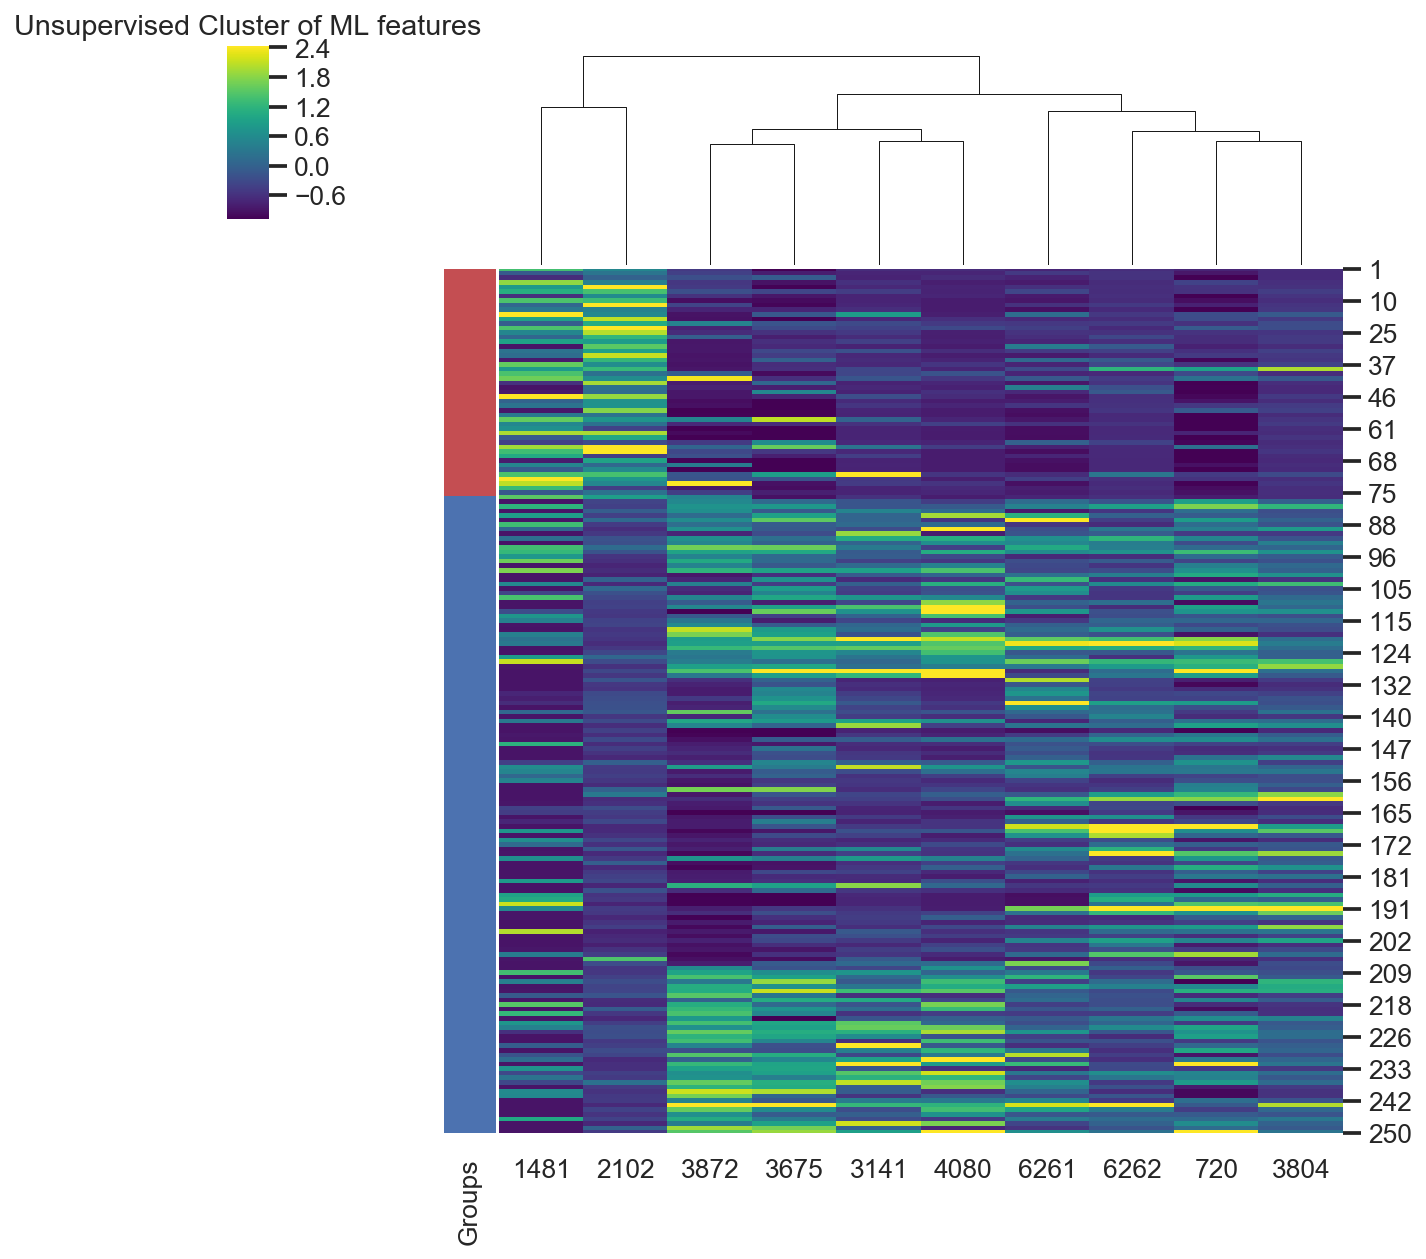

In [130]:
groups_two = biomarker2.pop('Groups')
biomarker2 = biomarker2.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker2, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)

### [Go back to notebook content](#0)

# 3. Chemical Information of Biomarkers
<a id="3"></a>

In [131]:
MS_labels_bmarkers = MS_labels[MS_labels.ID.isin(MLfeatures.columns)]
print(MS_labels_bmarkers.shape)
MS_labels_bmarkers.head()

(10, 5)


,ID,Mode,RT [min],Name,Formula
719,720,positive,2.562,2-Aminoacetophenone;O-Acetylaniline,C8 H9 N O
1480,1481,positive,6.290,1481,NaN
2101,2102,positive,3.449,"N,N-Diisopropylethylamine (DIPEA)",C8 H19 N
3140,3141,positive,1.133,3141,C7 H18 N8 O6 S
3674,3675,positive,1.184,3675,NaN


In [123]:
MS_labels_qmarkers = MS_labels[MS_labels.ID.isin(qfeatures.columns)]
print(MS_labels_qmarkers.shape)
MS_labels_qmarkers.head()

(433, 5)


,ID,Mode,RT [min],Name,Formula
0,1,positive,2.317,1,NaN
8,9,positive,1.901,5-Acetylamino-6-amino-3-methyluracil,C7 H10 N4 O3
94,95,positive,1.898,"3-(1H-1,2,4-Triazol-3-yl)alanine",C5 H8 N4 O2
146,147,positive,2.580,147,C33 H41 N O6 P2
162,163,positive,2.654,Venlafaxine,C17 H27 N O2


MS_labels_bmarkers.to_excel('RCC_20features.xlsx')

MS_labels_qmarkers.to_excel('RCC_472features.xlsx')

In [124]:
biomarker_v1 = pd.read_excel('biomarker_v1.xlsx')
#biomarker_v1.head()

__Intersection of Biomarkers__

In [125]:
biomarker_int = list(set(biomarker_v1.columns) & set(MS_labels_bmarkers['Name']))
print (len(biomarker_int))
biomarker_int

8


[3872,
 3141,
 '2-Aminoacetophenone;O-Acetylaniline',
 1481,
 4080,
 6261,
 6262,
 'N,N-Diisopropylethylamine (DIPEA)']

In [126]:
qfeatures_v1 = pd.read_excel('qfeatures_v1.xlsx')
#qfeatures_v1.head()

__Intersection of qmarkers__

In [127]:
qmarker_int = list(set(qfeatures_v1['Features']) & set(MS_labels_qmarkers['Name']))
print (len(qmarker_int))

388
